# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [ ]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import datetime

from scipy.stats import chi2_contingency
from scipy.stats import chi2

from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, stddev,col, concat, desc, isnan, explode, lit, count, when, sort_array, asc, avg, min, max, split, udf, isnull, countDistinct, rand
from pyspark.sql.functions import min as fmin
from pyspark.sql.functions import max as fmax
from pyspark.sql.types import IntegerType
from pyspark.sql.types import StringType

from pyspark.ml import Pipeline

from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import LogisticRegression
from pyspark.sql import Row
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.window import Window
%matplotlib inline


In [ ]:
# Create a Spark Session
spark = SparkSession \
.builder \
.appName('Sparkify') \
.getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [ ]:
# Load data and store it into a Spark dataframe
path = "mini_sparkify_event_data.json"
df = spark.read.json(path)

In [ ]:
# Structure of the dataframe
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [ ]:
# Print first line
df = spark.read.json('mini_sparkify_event_data.json')
df.show(1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
only showi

In [ ]:
# Describe user ID
df.count()

286500

In [ ]:
# Check userId null values
df.filter(isnull(df['userId'])).count()

0

In [ ]:
# Check sessionId null values
df.filter(isnull(df['sessionId'])).count()

0

In [ ]:
# Check userId missing values
df.filter(df['userId']=='').count()

8346

In [ ]:
# Check sessionId missing values
df.filter(df['sessionId']=='').count()

0

In [ ]:
# Remove userId with no values
df_clean = df.filter(df['userId']!='')

In [ ]:
df_clean.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

In [ ]:
# Sparksql
# Create a temporary view to perform SQL operations
df_clean.createOrReplaceTempView("Sparkify_clean")

In [ ]:
# Explore auth by user
spark.sql('''
        SELECT auth,COUNT(DISTINCT userId) AS distinct_users
        FROM Sparkify_clean
        GROUP BY auth
        ORDER BY distinct_users DESC
''').show()

+---------+--------------+
|     auth|distinct_users|
+---------+--------------+
|Logged In|           225|
|Cancelled|            52|
+---------+--------------+



In [ ]:
# Explore Gender
gender_count = spark.sql('''
        SELECT gender,COUNT(DISTINCT userId) AS distinct_users
        FROM Sparkify_clean
        GROUP BY gender
        ORDER BY distinct_users DESC
''').show()

+------+--------------+
|gender|distinct_users|
+------+--------------+
|     M|           121|
|     F|           104|
+------+--------------+



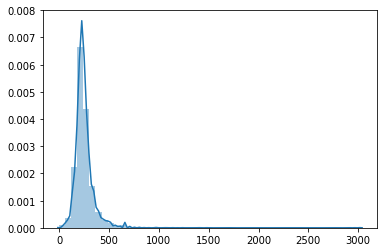

In [ ]:
# Explore length distribution
length = spark.sql('''
        SELECT length
        FROM Sparkify_clean
''').toPandas()

# Length Density viz
sns.distplot(length.dropna())

In [ ]:
# Explore level type
spark.sql('''
        SELECT level,COUNT(DISTINCT userId) AS user_counts
        FROM Sparkify_clean
        GROUP BY level
        ORDER BY user_counts DESC
''').show()

+-----+-----------+
|level|user_counts|
+-----+-----------+
| free|        195|
| paid|        165|
+-----+-----------+



In [ ]:
# Explore page by user
spark.sql('''
        SELECT page,COUNT(userId) AS user_counts
        FROM Sparkify_clean
        GROUP BY page
        ORDER BY user_counts DESC
''').show()

+--------------------+-----------+
|                page|user_counts|
+--------------------+-----------+
|            NextSong|     228108|
|           Thumbs Up|      12551|
|                Home|      10082|
|     Add to Playlist|       6526|
|          Add Friend|       4277|
|         Roll Advert|       3933|
|              Logout|       3226|
|         Thumbs Down|       2546|
|           Downgrade|       2055|
|            Settings|       1514|
|                Help|       1454|
|             Upgrade|        499|
|               About|        495|
|       Save Settings|        310|
|               Error|        252|
|      Submit Upgrade|        159|
|    Submit Downgrade|         63|
|              Cancel|         52|
|Cancellation Conf...|         52|
+--------------------+-----------+



### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.


In [ ]:
# Add a new colum called time to see clearly the timestamp
get_datetime = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
df_clean = df_clean.withColumn("datetime", get_datetime(df_clean.ts))

In [ ]:
#next, let's take a look at the userId 100001
df_clean.select(['datetime','userId','page','artist','song']).filter(df_clean['userId'] == 100001)\
.sort('datetime',ascending=False).show(20)

+-------------------+------+--------------------+--------------------+--------------------+
|           datetime|userId|                page|              artist|                song|
+-------------------+------+--------------------+--------------------+--------------------+
|2018-10-02 16:36:45|100001|Cancellation Conf...|                null|                null|
|2018-10-02 16:34:34|100001|              Cancel|                null|                null|
|2018-10-02 16:34:33|100001|         Roll Advert|                null|                null|
|2018-10-02 16:33:52|100001|            NextSong|            Harmonia|       Sehr kosmisch|
|2018-10-02 16:29:46|100001|                Home|                null|                null|
|2018-10-02 16:29:19|100001|              Logout|                null|                null|
|2018-10-02 16:29:18|100001|            NextSong|           Lady GaGa|           Alejandro|
|2018-10-02 16:24:34|100001|            NextSong|Michael BublÃÂ© ...|Quando_ Qu

In [ ]:
# Create a churn column which will contain 1 if the user cancelled, 0 otherwise
cancellation_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

df_clean = df_clean.withColumn("churn", cancellation_event('page'))
windowval = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
df_clean = df_clean.withColumn("churn",Fsum("churn").over(windowval))

In [ ]:
# Use userId=100001 to confirm that the column Churn is indeed == 1 when the page event is 'Cancellation confirmation'
df_clean.select(['datetime','userId','page','artist','song','churn']).filter(df_clean['userId'] == 100005)\
.sort('datetime',ascending=False).show(10)

+-------------------+------+--------------------+---------------+--------------------+-----+
|           datetime|userId|                page|         artist|                song|churn|
+-------------------+------+--------------------+---------------+--------------------+-----+
|2018-10-19 17:57:05|100005|Cancellation Conf...|           null|                null|    1|
|2018-10-19 17:56:50|100005|              Cancel|           null|                null|    1|
|2018-10-19 17:56:49|100005|            Settings|           null|                null|    1|
|2018-10-19 17:56:43|100005|                Help|           null|                null|    1|
|2018-10-19 17:56:40|100005|            NextSong|      Chris Rea|Driving Home For ...|    1|
|2018-10-19 17:52:10|100005|            NextSong|    Gipsy Kings|         Trista Pena|    1|
|2018-10-19 17:49:21|100005|            NextSong|  Flat Duo Jets|     My Life My Love|    1|
|2018-10-19 17:42:56|100005|            NextSong|Jimmy Eat World|     

In [ ]:
# Create a downgrade column which will contain 1 if the user downgrade, 0 otherwise
dwngrade_event = udf(lambda x: 1 if x == "Downgrade" else 0, IntegerType())

df_clean = df_clean.withColumn("downgrade", dwngrade_event('page'))
#windowval = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
#df_clean = df_clean.withColumn("downgrade",Fsum("downgrade").over(windowval))

In [ ]:
# Use userId=100001 to confirm that the column Churn is indeed == 1 when the page event is 'Cancellation confirmation'
df_clean.select(['datetime','userId','page','artist','song','downgrade']).filter(df_clean['userId'] == 73)\
.sort('datetime',ascending=False).show(10)

+-------------------+------+--------------------+--------------------+--------------------+---------+
|           datetime|userId|                page|              artist|                song|downgrade|
+-------------------+------+--------------------+--------------------+--------------------+---------+
|2018-10-24 17:33:07|    73|Cancellation Conf...|                null|                null|        0|
|2018-10-24 17:32:19|    73|              Cancel|                null|                null|        0|
|2018-10-24 17:32:18|    73|           Downgrade|                null|                null|        1|
|2018-10-24 17:31:59|    73|            NextSong|       M.A. Numminen|         TULENLIEKKI|        0|
|2018-10-24 17:27:36|    73|            NextSong|HÃÂ©roes del Sil...|      La Lluvia Gris|        0|
|2018-10-24 17:23:59|    73|            NextSong|          Yellowcard|    Light Up The Sky|        0|
|2018-10-24 17:21:16|    73|            NextSong|        Kenny Rogers|Christmas Is

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [ ]:
# Print again the dataframe schema
df_clean.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- datetime: string (nullable = true)
 |-- churn: long (nullable = true)
 |-- downgrade: integer (nullable = true)



In [ ]:
print('number of distinct users in sparkify : {}'\
    .format(df_clean.select('userId').drop_duplicates().count()))

number of distinct users in sparkify : 225


In [ ]:
# Total amount of churned users
print('total amount of churned users : {}'.format(df_clean.select('userId')\
                                            .where(df_clean.churn == 1).drop_duplicates().count()))

total amount of churned users : 52


In [ ]:
print('percentage of churned users : {}%'\
      .format(round(100*(df_clean.select('userId').where(df_clean.churn == 1)\
                         .drop_duplicates().count())/df_clean.select('userId')\
                         .drop_duplicates().count())))

percentage of churned users : 23%


In [ ]:
# Get churn rates based on Gender
pd_gender = df_clean.select(['userId','churn','gender']).\
drop_duplicates(["userId","churn",'gender']).groupby(["churn","gender"]).count().toPandas()
pd_gender

,churn,gender,count
0,0,F,84
1,1,M,32
2,1,F,20
3,0,M,89


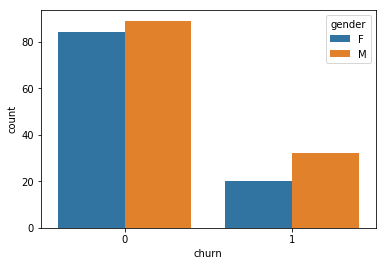

In [ ]:
# Gender churn viz
sns.barplot(x='churn',y='count',hue='gender',data=pd_gender)

In [ ]:
# contingency table
table = [[pd_gender.iat[1,2], pd_gender.iat[3,2],],[pd_gender.iat[2,2],pd_gender.iat[0,2]]]
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)

# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))

#If Statistic >= Critical Value: significant result, reject null hypothesis (H0), dependent.
#If Statistic < Critical Value: not significant result, fail to reject null hypothesis (H0), independent.

if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0), gender seems to be not significant in determining churn or not')


[[32, 89], [20, 84]]
dof=1
[[ 27.96444444  93.03555556]
 [ 24.03555556  79.96444444]]
probability=0.950, critical=3.841, stat=1.258
Independent (fail to reject H0)
significance=0.050, p=0.262
Independent (fail to reject H0), gender seems to be not significant in determining churn or not


In [ ]:
# Level churn
pd_item = df_clean.select(['userId','churn','level']).\
drop_duplicates(["userId","churn",'level']).groupby(["churn","level"]).count().toPandas()

In [ ]:
pd_item

,churn,level,count
0,1,paid,36
1,1,free,46
2,0,free,149
3,0,paid,129


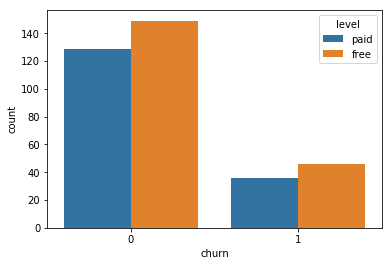

In [ ]:
# Level churn viz
sns.barplot(x='churn',y='count',hue='level',data=pd_item)

In [ ]:
# contingency table
table = [[pd_item.iat[1,2], pd_item.iat[2,2],],[pd_item.iat[0,2],pd_item.iat[3,2]]]
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)

# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))

#If Statistic >= Critical Value: significant result, reject null hypothesis (H0), dependent.
#If Statistic < Critical Value: not significant result, fail to reject null hypothesis (H0), independent.

if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0), item seems to be not significant in determining churn or not')


[[46, 149], [36, 129]]
dof=1
[[  44.41666667  150.58333333]
 [  37.58333333  127.41666667]]
probability=0.950, critical=3.841, stat=0.075
Independent (fail to reject H0)
significance=0.050, p=0.785
Independent (fail to reject H0), item seems to be not significant in determining churn or not


In [ ]:
# Length churn stats
df_clean.select(["churn", "length"]).groupby(["churn"]).agg(avg('length').alias('mean_length'), 
                                                                     stddev('length').alias('stdev_length'),
                                                                    fmax('length').alias('max_length'),
                                                                    fmin('length').alias('min_length')).show()

+-----+------------------+------------------+----------+----------+
|churn|       mean_length|      stdev_length|max_length|min_length|
+-----+------------------+------------------+----------+----------+
|    0|249.20913538880816|  98.6258830014688|3024.66567|   0.78322|
|    1|248.63279564406218|102.38497717575477|3024.66567|   4.04853|
+-----+------------------+------------------+----------+----------+



In [ ]:
# Create two datasets; churned users vs.  active users
churned = df_clean.select(['userId','page']).where(df_clean.churn == 1).groupby('page').agg(count("userId")).toPandas()
active = df_clean.select(['userId','page']).where(df_clean.churn == 0).groupby('page').agg(count("userId")).toPandas()

In [ ]:
active['churned'] = 'No'
active['%'] = round(100*active['count(userId)']/np.sum(active['count(userId)']),1)
active = active.drop(labels=['count(userId)'],axis=1)
active

,page,churned,%
0,Submit Downgrade,No,0.0
1,Thumbs Down,No,0.9
2,Home,No,3.6
3,Downgrade,No,0.7
4,Roll Advert,No,1.3
5,Logout,No,1.1
6,Save Settings,No,0.1
7,About,No,0.2
8,Settings,No,0.5
9,Add to Playlist,No,2.4


In [ ]:
churned['churned'] = 'Yes'
churned['%'] = round(100*churned['count(userId)']/np.sum(churned['count(userId)']),1)
churned= churned.drop(labels=['count(userId)'],axis=1)
churned

,page,churned,%
0,Cancel,Yes,0.1
1,Submit Downgrade,Yes,0.0
2,Thumbs Down,Yes,1.1
3,Home,Yes,3.7
4,Downgrade,Yes,0.8
5,Roll Advert,Yes,2.2
6,Logout,Yes,1.2
7,Save Settings,Yes,0.1
8,Cancellation Confirmation,Yes,0.1
9,About,Yes,0.1


In [ ]:
users = pd.concat([churned,active],sort=False)

In [ ]:
users

,page,churned,%
0,Cancel,Yes,0.1
1,Submit Downgrade,Yes,0.0
2,Thumbs Down,Yes,1.1
3,Home,Yes,3.7
4,Downgrade,Yes,0.8
5,Roll Advert,Yes,2.2
6,Logout,Yes,1.2
7,Save Settings,Yes,0.1
8,Cancellation Confirmation,Yes,0.1
9,About,Yes,0.1


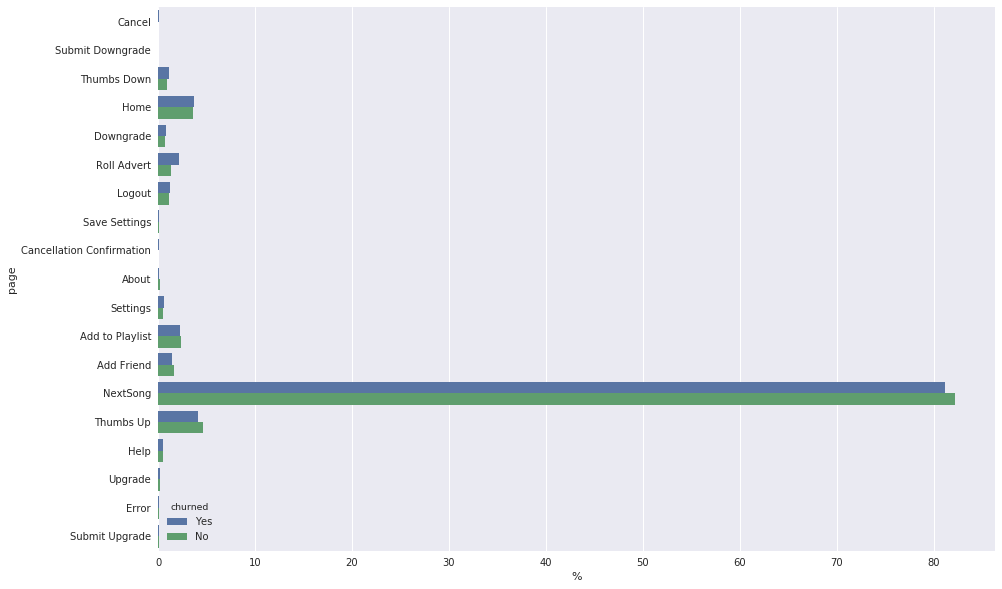

In [ ]:
fig=plt.figure(figsize=(15,10))
sns.set(font_scale=1)
snsbp = sns.barplot(data=users,x='%',y='page',capsize=0.2,hue='churned');
snsbp.set_xticklabels(snsbp.get_xticklabels(), rotation=90,minor=True);

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [ ]:
# Make gender to binary
gender = df_clean.dropDuplicates(['userId']).sort('userId')\
    .select(['userId','gender']).replace(['F','M'], ['1', '0'], 'gender')
gender.withColumn('gender', gender.gender.cast("int"))
gender.show(5)

+------+------+
|userId|gender|
+------+------+
|    10|     0|
|   100|     0|
|100001|     1|
|100002|     1|
|100003|     1|
+------+------+
only showing top 5 rows



In [ ]:
gender.count()

225

In [ ]:
# Number of songs played
songs = df_clean.where(df_clean.song!='null').groupby('userId')\
    .agg(count(df_clean.song).alias('songs_played')).orderBy('userId')\
    .select(['userId','songs_played'])
songs.show(5)

+------+------------+
|userId|songs_played|
+------+------------+
|    10|         673|
|   100|        2682|
|100001|         133|
|100002|         195|
|100003|          51|
+------+------------+
only showing top 5 rows



In [ ]:
songs.count()

225

In [ ]:
# Number of roll advertisement
ads = df_clean.where(df_clean.page=='Roll Advert') \
    .groupby(['userId']).agg(count(col('page')).alias('roll_advert'))\
    .orderBy('userId').select(['userId','roll_advert'])

ads.show(5)

+------+-----------+
|userId|roll_advert|
+------+-----------+
|    10|          1|
|   100|         25|
|100001|         14|
|100002|          3|
|100003|          9|
+------+-----------+
only showing top 5 rows



In [ ]:
ads.count()

207

In [ ]:
# Number of settings in pages
settings = df_clean.where(df_clean.page=='Settings')\
    .groupby(['userId']).agg(count(col('page')).alias('settings'))\
    .orderBy('userId').select(['userId','settings'])

settings.show(5)

+------+--------+
|userId|settings|
+------+--------+
|    10|       7|
|   100|      11|
|100001|       1|
|100004|      11|
|100005|       2|
+------+--------+
only showing top 5 rows



In [ ]:
settings.count()

195

In [ ]:
# Number of friends
addfriend = df_clean.where(df_clean.page=='Add Friend')\
    .groupby(['userId']).agg(count(col('page')).alias('add_friend'))\
    .orderBy('userId').select(['userId','add_friend'])

addfriend.show(5)

+------+----------+
|userId|add_friend|
+------+----------+
|    10|        12|
|   100|        49|
|100001|         2|
|100002|         1|
|100004|        19|
+------+----------+
only showing top 5 rows



In [ ]:
# Number of thumbs up and thumbs down
thumbsup = df_clean.where(df_clean.page=='Thumbs Up')\
    .groupby(['userId']).agg(count(col('page')).alias('thumbsUps'))\
    .orderBy('userId').select(['userId','thumbsUps'])

thumbsdown = df_clean.where(df_clean.page=='Thumbs Down')\
    .groupby(['userId']).agg(count(col('page')).alias('thumbsDowns'))\
    .orderBy('userId').select(['userId','thumbsDowns'])

thumbsup.show(5)

+------+---------+
|userId|thumbsUps|
+------+---------+
|    10|       37|
|   100|      148|
|100001|        8|
|100002|        5|
|100003|        3|
+------+---------+
only showing top 5 rows



In [ ]:
# Average number of songs played per session per userId
sessions_songs = df_clean.select(['userId','song','sessionId'])\
                    .groupby(['userId','sessionId'])\
                    .count().groupby(['userId']).agg({'count':'avg'})

sessions_songs = sessions_songs.withColumnRenamed("avg(count)", "avg_session")
sessions_songs.show()

+------+------------------+
|userId|       avg_session|
+------+------------------+
|100010| 54.42857142857143|
|200002|              79.0|
|   125|              11.0|
|    51|             246.4|
|   124| 166.3793103448276|
|     7|28.714285714285715|
|    54| 92.89189189189189|
|    15|151.86666666666667|
|   155|             167.0|
|100014|51.666666666666664|
|   132|             144.0|
|   154|39.333333333333336|
|   101|             214.9|
|    11|              53.0|
|300017| 70.28571428571429|
|   138|             164.6|
|    29|105.97058823529412|
|    69|149.11111111111111|
|100021|              63.8|
|    42| 90.57446808510639|
+------+------------------+
only showing top 20 rows



In [ ]:
# Length churn stats
length = df_clean.select(['userId', "length"]).groupby(['userId']).agg(avg('length').alias('mean_length'))
length.show()

+------+------------------+
|userId|       mean_length|
+------+------------------+
|100010|  243.421444909091|
|200002|242.91699209302305|
|   125|261.13913750000006|
|    51|247.88055082899118|
|   124|248.17653659965674|
|     7| 253.5605806666668|
|    54|250.38539934530132|
|    15|249.37701452978064|
|   155| 242.4137706097561|
|   132|250.58034431535253|
|   154| 245.9526655952382|
|100014|263.43763455252935|
|   101|249.00612947690533|
|    11| 246.7851051622872|
|   138|247.56032983574826|
|300017|  247.083419661344|
|    29|249.18017257926053|
|    69|254.27913390222213|
|100021| 250.5790245217391|
|    42|246.79344140218322|
+------+------------------+
only showing top 20 rows



In [ ]:
# Number of songs added by the user to playlist
playlist = df_clean.select(['userId','page'])\
                .filter(df_clean.page == 'Add to Playlist')\
                .groupby('userId').count()

playlist = playlist.withColumnRenamed("count", "addtoplaylist")
playlist.show()

+------+-------------+
|userId|addtoplaylist|
+------+-------------+
|100010|            7|
|200002|            8|
|    51|           52|
|   124|          118|
|     7|            5|
|    15|           59|
|    54|           72|
|   155|           24|
|   132|           38|
|   154|            1|
|100014|            7|
|   101|           61|
|    11|           20|
|   138|           67|
|300017|          113|
|    29|           89|
|    69|           33|
|100021|            7|
|    42|          104|
|   112|            7|
+------+-------------+
only showing top 20 rows



In [ ]:
# Number of songs added by the user to playlist
downgrade = df_clean.select(['userId','downgrade'])\
                .filter(df_clean.downgrade == 1).groupby('userId').count()
                #.drop_duplicates(["userId","downgrade"])
                

downgrade = downgrade.withColumnRenamed("count", "downgrade")
downgrade.show()

+------+---------+
|userId|downgrade|
+------+---------+
|200002|        5|
|    51|       23|
|   124|       41|
|    54|       39|
|    15|       28|
|   155|       12|
|   132|       19|
|100014|        3|
|   101|       22|
|    11|        5|
|   138|       21|
|300017|       25|
|    29|       18|
|    69|        9|
|    42|       37|
|    87|        1|
|    73|        1|
|     3|        2|
|   113|       16|
|    30|        6|
+------+---------+
only showing top 20 rows



In [ ]:
# Number of days spent using the service since registration date
loyalty = df_clean.withColumn("loyalty" , (df_clean.ts-df_clean.registration)/(1000*60*60*24))\
                    .select(['userId','loyalty']).groupby('userId').max('loyalty').alias('loyalty')

loyalty = loyalty.withColumnRenamed("max(loyalty)", "loyalty")

loyalty.show()

+------+------------------+
|userId|           loyalty|
+------+------------------+
|100010| 55.64365740740741|
|200002| 70.07462962962963|
|   125| 71.31688657407408|
|    51|19.455844907407407|
|   124|131.55591435185184|
|     7| 72.77818287037037|
|    54|110.75168981481481|
|    15|56.513576388888886|
|   155|23.556018518518517|
|   132|  66.8891087962963|
|   154|23.872037037037035|
|100014| 85.08340277777778|
|   101|        53.9659375|
|    11|124.47825231481481|
|   138| 66.62668981481481|
|300017| 74.35851851851852|
|    29|60.104050925925925|
|    69| 71.42444444444445|
|100021| 64.73886574074074|
|    42| 67.11364583333334|
+------+------------------+
only showing top 20 rows



In [ ]:
# Create final dataset
feature_list = [gender, songs, ads, addfriend, thumbsup, thumbsdown, \
                loyalty, downgrade, playlist, length, sessions_songs]

df = df_clean.dropDuplicates(['userId']).sort('userId').select(['userId','churn'])
for feature in feature_list:
    df = df.join(feature,'userId', how='left').na.fill(0)

df = df.withColumnRenamed("churn", "label")
df.show()

+------+-----+------+------------+-----------+----------+---------+-----------+------------------+---------+-------------+------------------+------------------+
|userId|label|gender|songs_played|roll_advert|add_friend|thumbsUps|thumbsDowns|           loyalty|downgrade|addtoplaylist|       mean_length|       avg_session|
+------+-----+------+------------+-----------+----------+---------+-----------+------------------+---------+-------------+------------------+------------------+
|100010|    0|     1|         275|         52|         4|       17|          5| 55.64365740740741|        0|            7|  243.421444909091| 54.42857142857143|
|200002|    0|     0|         387|          7|         4|       21|          6| 70.07462962962963|        5|            8|242.91699209302305|              79.0|
|   125|    1|     0|           8|          1|         0|        0|          0| 71.31688657407408|        0|            0|261.13913750000006|              11.0|
|   124|    0|     1|        4079|

In [ ]:
# Drop userid
df = df.drop('userId')

In [ ]:
# Transform to float
for feature in df.columns[1:]:
    df = df.withColumn(feature, df[feature].cast('float'))

In [ ]:
# This is the data we will use to train
df.printSchema()

root
 |-- label: long (nullable = true)
 |-- gender: float (nullable = true)
 |-- songs_played: float (nullable = true)
 |-- roll_advert: float (nullable = true)
 |-- add_friend: float (nullable = true)
 |-- thumbsUps: float (nullable = true)
 |-- thumbsDowns: float (nullable = true)
 |-- loyalty: float (nullable = false)
 |-- downgrade: float (nullable = true)
 |-- addtoplaylist: float (nullable = true)
 |-- mean_length: float (nullable = false)
 |-- avg_session: float (nullable = false)



In [ ]:
df.count()

225

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [ ]:
def undersample(df): 
    '''
    Implement undersample on dataset, return a balanced dataset.
    '''    
    # size of minority class(0)
    minoritySize = df.where(df.label == '1').count()
    
    # two classes with the same size
    df_min = df.where(df.label == '1')
    df_max = df.where(df.label == '0').sample(1.0, seed=7).limit(minoritySize)
    
    # concatenate them together
    result = df_min.union(df_max)
    
    #shuffle data
    result = result.orderBy(rand())
    return result

In [ ]:
df_bal = undersample(df)

In [ ]:
# Check the output
df_bal.groupby(df_bal.label).count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|   52|
|    1|   52|
+-----+-----+



In [ ]:
df_bal.printSchema()

root
 |-- label: long (nullable = true)
 |-- gender: float (nullable = true)
 |-- songs_played: float (nullable = true)
 |-- roll_advert: float (nullable = true)
 |-- add_friend: float (nullable = true)
 |-- thumbsUps: float (nullable = true)
 |-- thumbsDowns: float (nullable = true)
 |-- loyalty: float (nullable = false)
 |-- downgrade: float (nullable = true)
 |-- addtoplaylist: float (nullable = true)
 |-- mean_length: float (nullable = false)
 |-- avg_session: float (nullable = false)



In [ ]:
# Create VectorAssembler to push data to ML models
assembler = VectorAssembler(inputCols=df_bal.columns[1:],\
                            outputCol="inputFeatures")

# Normalize data
scaler = Normalizer(inputCol="inputFeatures", outputCol="ScaledFeatures");

In [ ]:
# ElasticNetParam corresponds to α and regParam corresponds to λ.
#model_lr = LogisticRegression(featuresCol="ScaledFeatures", labelCol="label", maxIter=10, regParam=0.01)
#model_rf = RandomForestClassifier(featuresCol="ScaledFeatures", labelCol="label")
#model_gbt = GBTClassifier(featuresCol="ScaledFeatures", labelCol="label")

In [ ]:
# Create Pipeline
#pipeline_lr = Pipeline(stages=[assembler, scaler, model_lr]);
#pipeline_rf = Pipeline(stages=[assembler, scaler, model_rf]);
#pipeline_gbt = Pipeline(stages=[assembler, scaler, model_gbt])

In [ ]:
# spilt data for Train and test 
train, test = df_bal.randomSplit([0.8, 0.2], seed=7);

In [ ]:
#test

In [ ]:
# Build Logistic Regression Classification Model

# Initiate Log Regression model

lr =  LogisticRegression(featuresCol="ScaledFeatures", labelCol="label", maxIter=10)

# Make pipeline for lr
pipeline_lr = Pipeline(stages=[assembler, 
                               scaler, 
                               lr
                              ]
                      )

# Grid search params
paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam,[0.0]) \
    .addGrid(lr.regParam,[0.01]) \
    .build()

# Cross-validation params
cv_lr = CrossValidator(estimator=pipeline_lr,
                             estimatorParamMaps=paramGrid_lr,
                             evaluator=MulticlassClassificationEvaluator(),
                             numFolds=5
                            )


# Build Random Forest Classification Model

# Initiate Random Forest model

model_rf = RandomForestClassifier(featuresCol="ScaledFeatures", labelCol="label")


# Make pipeline for rf
pipeline_rf = Pipeline(stages=[assembler, 
                               scaler, 
                               model_rf 
                              ]
                      )

# Grid search params
paramGrid_rf = ParamGridBuilder() \
    .addGrid(model_rf.maxDepth, [8, 16,20]) \
    .addGrid(model_rf.maxBins, [8, 16, 20]) \
    .addGrid(model_rf.impurity, ['gini','entropy']) \
    .build()
    
# Cross validation params
cv_rf = CrossValidator(estimator=pipeline_rf,
                       estimatorParamMaps=paramGrid_rf,
                       evaluator=MulticlassClassificationEvaluator(),
                       numFolds=5
                      )

In [ ]:
#import time
#from dateutil import tz
#from datetime import datetime

#rome_tz = tz.gettz("Europe/Rome")
#now = datetime.now(tz=rome_tz)
#print(now)

In [ ]:
# Fit models
import time
from dateutil import tz
from datetime import datetime

rome_tz = tz.gettz("Europe/Rome")
now = datetime.now(tz=rome_tz)
print(now)
#print(datetime.datetime.now())

start_time= time.time()

model_lr_fitted = cv_lr.fit(train);
model_rf_fitted = cv_rf.fit(train)
#model_rf_fitted = pipeline_rf.fit(train);
#model_gbt_fitted = pipeline_gbt.fit(train);

end_time= time.time()

print("Total execute time:{}".format(end_time-start_time))

2020-07-19 11:14:47.816730+02:00
Total execute time:7646.481378078461


In [ ]:
# Function to calculate Accuracy scores:
def model_performance_accuracy(model, test_data, metric = 'accuracy'):
    """ Calculate Model Scores using f1 metric 
        Input: 
            model- trained model or pipeline object
            metric- the metric used to measure performance
            data - data on which performance measurement should be done
        Output:
            score
    """
    evaluator = MulticlassClassificationEvaluator(metricName = metric)
    prediction_result = model.transform(test_data)
    # find f1 score
    score = evaluator.evaluate(prediction_result)
    #return score
    return score

In [ ]:
# Print Models Accuracy
print("Logistic Regression Classifier Accuracy:{}".format(model_performance_accuracy(model_lr_fitted, test)));
print("Random Forest Classifier Accuracy:{}".format(model_performance_accuracy(model_rf_fitted, test)));
#print("GBTClassifier  Classifier Accuracy:{}".format(model_performance_accuracy(model_gbt_fitted, test)));

Logistic Regression Classifier Accuracy:0.7647058823529411
Random Forest  Classifier Accuracy:0.47058823529411764


In [ ]:
feature_importances = model_rf_fitted.bestModel.stages[2].featureImportances.values.tolist()

In [ ]:
feature_importances

[0.0526684546051774,
 0.08374028916518438,
 0.08036777049819223,
 0.08577652824385731,
 0.1265252967779142,
 0.11148366815144042,
 0.11078729214315644,
 0.06948804597697564,
 0.08954813077401333,
 0.0713712247674207,
 0.11824329889666799]

In [ ]:
feature_importance_df = pd.DataFrame({'feature_importance': feature_importances, 'feature name': df_bal.columns[1:]})

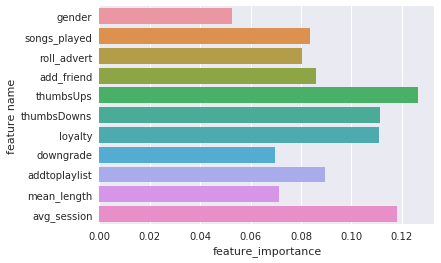

In [ ]:
sns.barplot(x='feature_importance', y='feature name', data=feature_importance_df)

In [ ]:
# Function to calculate F-1 scores:
def model_performance_f1(model, test_data, metric = 'f1'):
    """ Calculate Model Scores using f1 metric 
        Input: 
            model- trained model or pipeline object
            metric- the metric used to measure performance
            data - data on which performance measurement should be done
        Output:
            score
    """
    evaluator = MulticlassClassificationEvaluator(metricName = metric)
    prediction_result = model.transform(test_data)
    # find f1 score
    score = evaluator.evaluate(prediction_result)
    #return score
    return score

In [ ]:
# Print Models F-1 score
print("Logistic Regression Classifier F1-Score:{}".format(model_performance_f1(model_lr_fitted, test)));
print("Random Forest Classifier F1-Score:{}".format(model_performance_f1(model_rf_fitted, test)));
#print("GBTClassifier  Classifier F1-Score:{}".format(model_performance(model_gbt_fitted, test)));

Logistic Regression Classifier F1-Score:0.7630718954248366
Random Forest Classifier F1-Score:0.45944272445820433


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.